# Evaluation of Trading Strategy

In this notebook, I seek to compare two simple trading strategies on various metrics. The focus is the calculation of the metrics, rather than the effectiveness of the strategy.

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [82]:
ticker = 'NXE'
stock_data = yf.download(ticker, start='2019-01-01', end='2025-01-01', auto_adjust=True)
stock_data.index = pd.to_datetime(stock_data.index)
stock_data = stock_data.iloc[:, 0]
stock_data.name = 'Close'
stock_data.head(5)

[*********************100%***********************]  1 of 1 completed


Date
2019-01-02    1.77
2019-01-03    1.72
2019-01-04    1.81
2019-01-07    1.85
2019-01-08    1.87
Name: Close, dtype: float64

# Create Trading Strategy

We will compare two Simple Moving Average (SMA) strategy with different periods, where we go long when price crosses above the SMA and short when price crosses below it.

In [216]:
class MovingAverage:
    def simple_ma(self, price_data:pd.Series, window:int=20) -> pd.Series:
        sma = price_data.rolling(window).mean()
        sma.name = f'SMA{window}'
        return sma

ma = MovingAverage()
sma_20 = ma.simple_ma(stock_data, 20)
sma_50 = ma.simple_ma(stock_data, 50)
df = pd.concat([stock_data, sma_20, sma_50], axis=1)
df.tail(5)

,Close,SMA20,SMA50
Date,,,
2024-12-24,6.91,7.7700,7.7302
2024-12-26,6.86,7.6975,7.7220
2024-12-27,6.83,7.6235,7.6980
2024-12-30,6.68,7.5355,7.6694
2024-12-31,6.60,7.4545,7.6348


In [217]:
def mean_cross_trade(price_series:pd.Series, mean:pd.Series, tolerance:float=0.0001) -> pd.Series:
    """
    Mainly to indicate long and short whenever price goes above or below the mean.
    
    args:
        price_series: Price data of an asset.
        mean: Either a constant or a moving average that is the same size as the price_series.
        tolerance: A constant to reduce noise.
        
    return:
        A panda series containing the following values:
            -1: Cross below the mean
            1: Cross above the mean
            0: No crosses
    """
    
    cross = 0
    signal = []
    for px, ma in zip(price_series, mean):
        if px > ma+tolerance and cross != 1:
            cross = 1
            signal.append(cross)
        elif px < ma-tolerance and cross != -1:
            cross = -1
            signal.append(cross)
        else:
            signal.append(0)
    
    #Set initial value to 0 as price did not cross the mean
    signal[0] = 0
    return signal

#Filter to the 50th day for the same starting point
df = df.iloc[49:]

df['SMA20_Cross'] = mean_cross_trade(df['Close'], df['SMA20'], 0)
df['SMA50_Cross'] = mean_cross_trade(df['Close'], df['SMA50'], 0)
df.head(10)

,Close,SMA20,SMA50,SMA20_Cross,SMA50_Cross
Date,,,,,
2019-03-14,1.70,1.6625,1.7510,0,0
2019-03-15,1.71,1.6590,1.7498,0,0
2019-03-18,1.69,1.6555,1.7492,0,0
2019-03-19,1.69,1.6530,1.7468,0,0
2019-03-20,1.72,1.6515,1.7442,0,0
2019-03-21,1.71,1.6495,1.7410,0,0
2019-03-22,1.66,1.6455,1.7352,0,0
2019-03-25,1.67,1.6425,1.7290,0,0
2019-03-26,1.65,1.6440,1.7244,0,0


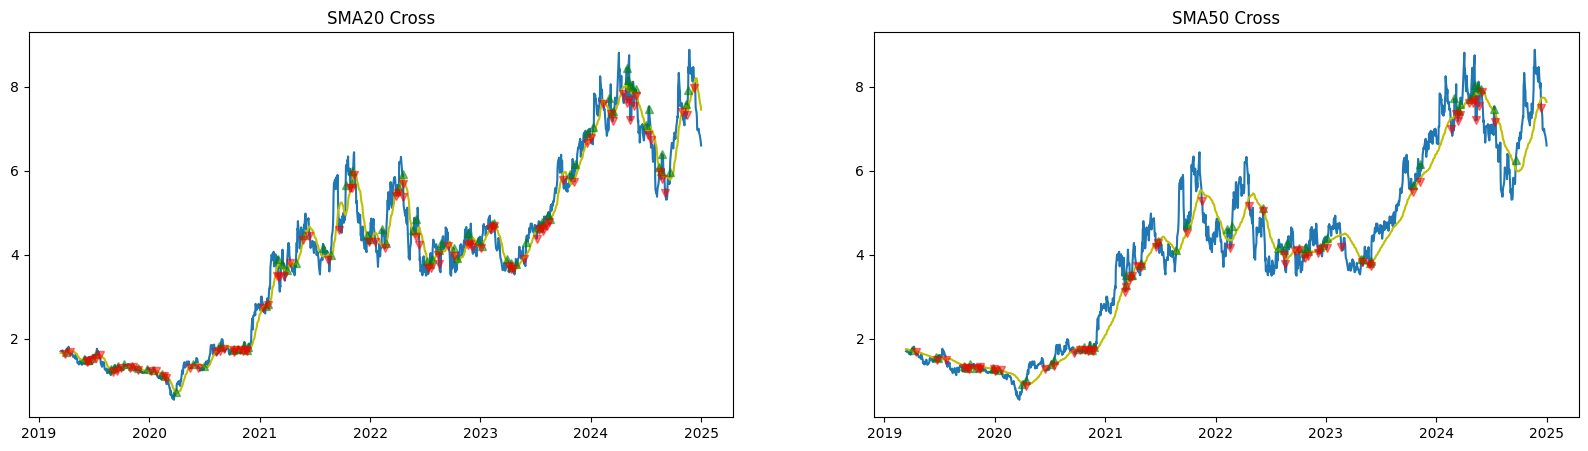

In [218]:
fig, axes = plt.subplots(ncols=2, figsize=(20,5))

#SMA20
axes[0].set_title(f'SMA20 Cross')
axes[0].plot(df['Close'])
axes[0].plot(df['SMA20'], color='y')
pos_mask = df['Close'].loc[df['SMA20_Cross'] == 1]
axes[0].plot(pos_mask, '^', color='g', markersize=6, alpha=0.5)
neg_mask = df['Close'].loc[df['SMA20_Cross'] == -1]
axes[0].plot(neg_mask, 'v', color='r', markersize=6, alpha=0.5)

#SMA50
axes[1].set_title(f'SMA50 Cross')
axes[1].plot(df['Close'])
axes[1].plot(df['SMA50'], color='y')
pos_mask = df['Close'].loc[df['SMA50_Cross'] == 1]
axes[1].plot(pos_mask, '^', color='g', markersize=6, alpha=0.5)
neg_mask = df['Close'].loc[df['SMA50_Cross'] == -1]
axes[1].plot(neg_mask, 'v', color='r', markersize=6, alpha=0.5)

plt.show()

# Execute Trading Strategies

In [219]:
class TradeBacktest:
    def __init__(self, price_series:pd.Series, cash:int=10000, commission:float=0):
        #Create Dataframe
        price_series.name = 'price'
        self.df = price_series.to_frame()
        self.df['equity'] = None
        self.df.iloc[0, 1] = cash
        
        self.cash = cash
        self.commission = commission
        self.position_details = None
        self.equity_curve = []
        self.win_loss = [] # (Profit, W/L)
        self.bankrupt = False
    
    def record_trade(self, profit:float=0, close:bool=False):
        """
        Updates record with a tuple containing (profit, win/loss).
        Win: 1, Lost: -1, Neutral: 0
        
        args:
            profit: Calculated from get_profit function.
            close: If False, an entry will be (None, None) as the trade is not closed.
        """
        if close:
            win_loss = 1 if profit > 0 else -1
            record_entry = (profit, win_loss)
            self.win_loss.append(record_entry)
        else:
            record_entry = (None, 0)
            self.win_loss.append(record_entry)
    
    def open_position(self, price:float, long_short:int, lot_size:int=10):
        """
        Initialize a position and pays for commission.
        
        args:
            price: How much it costs to purchase one share.
            long_short: 1 is long, -1 is short.
            lot_size: How many shares you wish to purchase.
            
        return:
            Update the cash position and equity curve.
            Update the trade position:
                pos_size: price*lot_size
                lot_size: How many shares you wish to purchase.
                long_short: 1 is long, -1 is short.
        """
        #Check Eligiblity
        pos_size = price*lot_size
        if self.cash < pos_size + self.commission:
            print(f"Not enough capital to purchase shares. \nCurrent Cash: {self.cash} \nPosition Size: {pos_size}")
            self.bankrupt = True
            return
        
        #Update equity curve
        self.cash -= self.commission
        self.equity_curve.append(self.cash)
        self.record_trade() #Update as None because trade has not closed
        
        #Update cash
        self.cash -= pos_size
        self.position_details = (pos_size, lot_size, long_short)
    
    def get_profit(self, price:float) -> float:
        pos_size, lot_size, long_short = self.position_details
        close_size = price*lot_size
        
        if long_short == 1:
            profit = close_size - pos_size
        elif long_short == -1:
            profit = pos_size - close_size
        
        return profit
    
    def close_position(self, price:float) -> float:
        """
        Closes a previously opened position and pays for commission.
        
        args:
            price: How much it costs to purchase one share.
            
        return:
            Updates the cash position, equity curve and record.
            Closes the trade position.
            profit: Profit/Loss resulting from the position, after commission.
        """
        
        profit = self.get_profit(price) - self.commission
        pos_size = self.position_details[0]
        self.cash = self.cash + profit + pos_size
        
        self.equity_curve.append(self.cash)
        self.record_trade(profit, close=True)
        self.position_details = None
    
    def mark_to_market(self, price:float):
        """
        Update the equity curve and record.
        """
        self.record_trade()
        if self.position_details is None:
            self.equity_curve.append(self.cash)
            return
        
        pos_size = self.position_details[0] 
        profit = self.get_profit(price)
        
        current_val = self.cash + profit + pos_size
        self.equity_curve.append(current_val)
    
    def ma_price_cross_strategy(self, entry_signals:pd.Series, lot_size:int=10):
        """
        Execute moving average vs price cross strategy.
        
        args:
            entry_signals: A panda series of 1 and -1, where 1 is long and -1 is short.
            lot_size: How many shares to purchase or short.
            
        return:
            Updates equity curve.
        """
        for signal, price in zip(entry_signals, self.df['price']):
            if signal == 0:
                self.mark_to_market(price)
                continue
            
            if self.position_details is None:
                self.open_position(price, signal, lot_size)
            else:
                self.close_position(price)
                self.equity_curve.pop() #Only include update after opening a new position
                self.open_position(price, signal, lot_size)
                self.win_loss.pop() #Only include update for closing an old position
            
            if self.bankrupt:
                self.declare_bankrupt()
                break
        
        self.df['equity'] = self.equity_curve
        self.df[['profit', 'win']] = self.win_loss
    
    def declare_bankrupt(self):
        """
        Update the remaining rows for equity and record.
        """
        remaining = len(self.df) - len(self.equity_curve)
        equity_remaining_entries = [self.cash]*remaining
        self.equity_curve.extend(equity_remaining_entries)
        
        record_remaining_entries = [(None, None)]*remaining
        self.win_loss.extend(record_remaining_entries)

In [220]:
cash, commission = 10000, 4
sma_20 = TradeBacktest(df['Close'], cash=cash, commission=commission)
sma_20.ma_price_cross_strategy(df['SMA20_Cross'])
sma_20.df = pd.concat([sma_20.df, df['SMA20_Cross']], axis=1)

sma_50 = TradeBacktest(df['Close'], cash=cash, commission=commission)
sma_50.ma_price_cross_strategy(df['SMA50_Cross'])
sma_50.df = pd.concat([sma_50.df, df['SMA50_Cross']], axis=1)

sma_20.df.tail(20)

,price,equity,profit,win,SMA20_Cross
Date,,,,,
2024-12-03,8.12,8385.380040,NaN,0.0,0
2024-12-04,8.33,8387.480041,NaN,0.0,0
2024-12-05,8.47,8388.880044,NaN,0.0,0
2024-12-06,8.37,8387.880040,NaN,0.0,0
2024-12-09,7.98,8375.980042,-3.400001,-1.0,-1
2024-12-10,7.99,8375.880044,NaN,0.0,0
2024-12-11,8.09,8374.880040,NaN,0.0,0
2024-12-12,7.79,8377.880042,NaN,0.0,0
2024-12-13,7.50,8380.780042,NaN,0.0,0


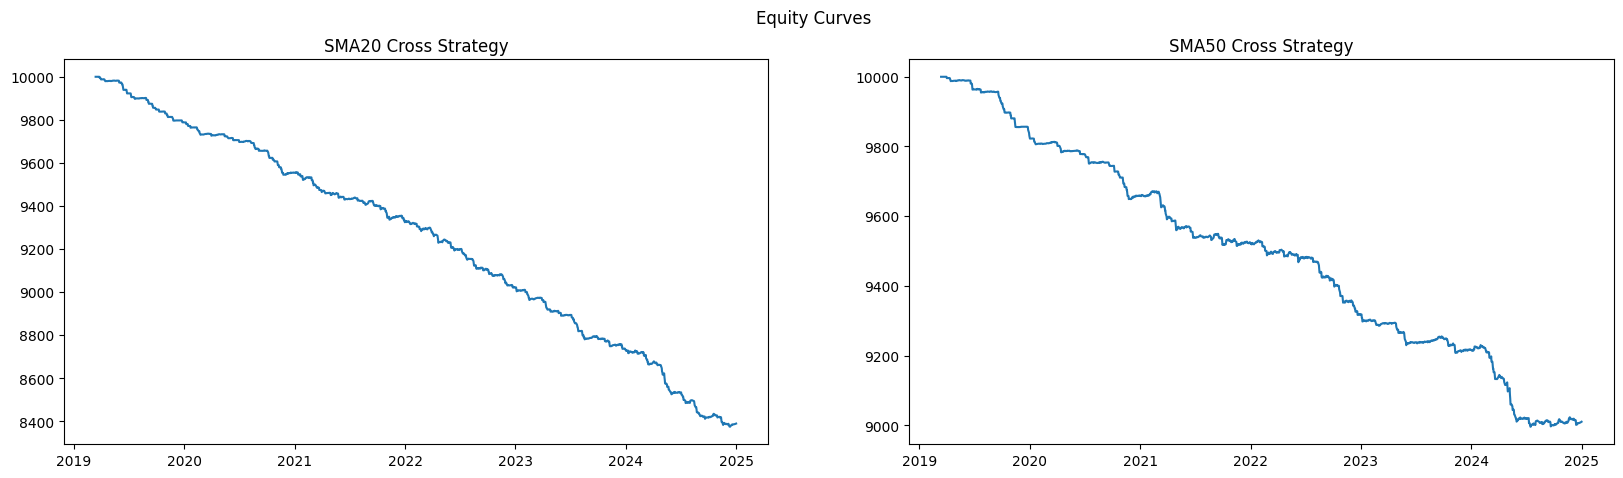

In [221]:
fig, axes = plt.subplots(ncols=2, figsize = (20,5))
fig.suptitle("Equity Curves")

axes[0].set_title("SMA20 Cross Strategy")
axes[0].plot(sma_20.df['equity'])

axes[1].set_title("SMA50 Cross Strategy")
axes[1].plot(sma_50.df['equity'])

plt.show()

# Calculate Metrics

When calculating percentage returns, we will use natural log.

Log returns or continuously compounded returns offer these key advantages:

1. Time additivity: Log returns can be easily added across periods. If you have daily log returns, you can sum them to get weekly, monthly, or annual returns without any adjustment.
2. Statistical properties: Log returns tend to be more normally distributed than simple returns, which makes them more suitable for many models that assume a normal distribution.
3. Symmetry: Log returns are symmetric for gains and losses of equal magnitude. A 10% gain followed by a 10% loss gives you a simple return of -1%, but log returns would sum exactly to zero.

In order to change from log return back to simple return, we do the following:
$$
\text{Simple Return} = \exp(\text{Log Return}) - 1
$$

In [222]:
prices = sma_20.df['price'].values
simple_returns = prices[1:]/prices[:-1] - 1
log_returns = np.log(prices[1:]/prices[:-1])

adjusted_cumprod_simple = np.cumprod(1+simple_returns)-1
terminal_simple_return = prices[-1]/prices[0] - 1
terminal_log_return = np.log(prices[-1]/prices[0])

#From the result, notice how log-return is more intuitive
print(f"Cumulative Sum of Simple Return: {np.sum(simple_returns):.6f} \nTerminal Simple Return: {terminal_simple_return:.6f}")
print(f"Cumprod of Simple Return: {adjusted_cumprod_simple[-1]:.6f}")
print(f"\nCumulative Sum of Log Return: {np.sum(log_returns):.6f} \nTerminal Log Return: {terminal_log_return:.6f}")
print(f"Adjusted Log Return: {np.exp(terminal_log_return)-1:.6f}")

Cumulative Sum of Simple Return: 2.493693 
Terminal Simple Return: 2.882353
Cumprod of Simple Return: 2.882353

Cumulative Sum of Log Return: 1.356441 
Terminal Log Return: 1.356441
Adjusted Log Return: 2.882353


## Risk-Adjusted Return

### Sharpe Ratio
Sharpe Ratio describes how much excess return you receive for the extra volatility from the riskier asset. A high Sharpe ratio indicates that the strategy generates returns that are good relative to its overall volatility.

$$
\text{Sharpe Ratio} = \frac {E[R_p - R_f]} {\sigma_p}
$$
where $R_p$ is the investment return, $R_f$ is the risk-free return and ${\sigma_p}$ is the volatility of the investment.

Typically, for risk-free return, we will use the current interest rate of the 3-months T-Bill (4.2%).

Source: https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=all&data=yieldAll
<br><br>

For trading strategies that do not hold positions overnight and where the cash position is reset everyday, a different formula is required.

$$
\text{Intraday Sharpe Ratio} = \frac {E[R_p]} {\sigma_p}
$$
where $R_p$ is the average P&L and ${\sigma_p}$ is the standard deviation of the P&L.
<br><br>

If we wish to scale our Sharpe Ratio by a certain time aspect, either by trading days or number of trades we can multiply by $\sqrt N$.
$$
\sigma^2_N = N_{days}*\sigma^2_{daily}
$$

$$
\sigma_N = \sqrt{N_{days}}*\sigma_{daily}
$$

For example, if we wish to annualize the Sharpe Ratio for daily and monthly returns:
$$
\text{Sharpe Ratio} = \sqrt{252} * \frac {E[R_p - R_f]} {\sigma_p}
$$

$$
\text{Sharpe Ratio} = \sqrt{12} * \frac {E[R_p - R_f]} {\sigma_p}
$$

In [223]:
def expected_return_volatility(log_return:np.array, t:int=0, downside_volatility:bool=False) -> tuple[float,float|None]:
    """
    Calculates the expected return and volatility of the portfolio.
    
    args:
        return_series: An array of returns in percentage term.
        t: Number of recent trading periods. Default to 0, if you wish to calculate lifetime.
        downside_volatility: If True, downside volatility will be calculated.
        
    return:
        A tuple containing:
            expected_return: Average return for the trading window.
            volatility: Standard deviation of returns or standard deviation of downside risks for the trading window.
    """
    if t != 0:
        t = len(log_return) - t
    arr_return = log_return[t:]
    expected_return = np.mean(arr_return)
    
    if downside_volatility:
        mask = arr_return < 0
        filter_arr_return = arr_return[mask]
        if len(filter_arr_return) == 0:
            return (expected_return, None)
        
        semi_variance = np.sum(np.square(filter_arr_return))/len(arr_return)
        volatility = np.sqrt(semi_variance)
    else:
        volatility = np.std(arr_return)
        
    return (expected_return, volatility)

def sharpe_ratio(portfolio_return:float, portfolio_volatility:float, risk_free:float=0, t:int=1) -> float|None:
    """
    Calculate the Sharpe Ratio of the portfolio or strategy.
    
    args:
        portfolio_return: Average return of the portfolio in a given timeframe.
        portfolio_volatility: Standard deviation of portfolio return in a given timeframe.
        risk_free: Typically, the 3-month T-Bill Rate divided by 365. If strategy is intrday, put 0.
        t: Number of trading periods that you wish to scale the Sharpe Ratio. For example, 252 for annualized.
    
    return:
        sharpe_ratio: how much excess return you receive for the extra volatility from the riskier asset, scaled to specified timeframe.
    """
    if portfolio_volatility == 0 or portfolio_volatility is None:
        return None
    
    sharpe_ratio = (portfolio_return-risk_free)/portfolio_volatility    
    scaled_sharpe_ratio = np.sqrt(t)*sharpe_ratio
    return scaled_sharpe_ratio

In [224]:
equity_curve = sma_20.df['equity'].values
sma_20_ln_return = np.log(equity_curve[1:] / equity_curve[:-1])
equity_curve = sma_50.df['equity'].values
sma_50_ln_return = np.log(equity_curve[1:] / equity_curve[:-1])

timeframes = [0, 30, 90, 180, 360]
sma_20_metrics, sma_50_metrics = {}, {}
ln_returns = (sma_20_ln_return, sma_50_ln_return)
sma_dicts = (sma_20_metrics, sma_50_metrics)    

for ln_return, sma_map in zip(ln_returns, sma_dicts):
    for t in timeframes:
        exp_return, vol = expected_return_volatility(ln_return, t=t)
        metric = sharpe_ratio(exp_return, vol, 0.042/365) #Daily returns: Daily risk-free rate
        key = f'Sharpe Ratio ({t}-days)' if t != 0 else f'Sharpe Ratio (Lifetime)'
        sma_map[key] = round(metric, 4)
        value = round(metric, 4)
        sma_map[key] = value
        print(f'{key}: {value}')
    print('')

Sharpe Ratio (Lifetime): -0.5773
Sharpe Ratio (30-days): -0.3117
Sharpe Ratio (90-days): -0.4342
Sharpe Ratio (180-days): -0.5305
Sharpe Ratio (360-days): -0.5122

Sharpe Ratio (Lifetime): -0.5566
Sharpe Ratio (30-days): -0.3164
Sharpe Ratio (90-days): -0.3816
Sharpe Ratio (180-days): -0.4303
Sharpe Ratio (360-days): -0.4534



### Sortino Ratio
Sortino Ratio examines risk-adjusted returns, but it only considers the downside risks. A high Sortino ratio calculated indicates that the strategy is effectively filtering out negative market conditions.
$$
\text{Sortino Ratio} = \frac {E[R_p - R_f]} {\sigma_d}
$$
where $R_p$ is the investment return, $R_f$ is the risk-free return and ${\sigma_d}$ is the downside volatility of the investment.
<br><br>
Instead of simply finding the standard deviation of the downside returns, we will calculate the normalized downside deviation. This approach is particularly useful for comparing strategies with different trading frequencies or strategies that have different proportions of time in the market vs cash. It gives a more favorable score to strategies that spend more time avoiding losses.
$$
\sigma_d^2 = \frac {\sum{R_d^2}} {N}
$$
$$
\sigma_d = \sqrt{\frac {\sum{R_d^2}} {N}}
$$
where $R_d$ is the downside returns and $N$ is the number of trading periods.

Source: https://corporatefinanceinstitute.com/resources/wealth-management/sortino-ratio-2/

In [225]:
def sortino_ratio(portfolio_return:float, downside_volatility:float, risk_free:float=0, t:int=1) -> float|None:
    """
    Calculate the Sortino Ratio of the portfolio or strategy.
    
    args:
        portfolio_return: Average return of the portfolio in a given timeframe.
        downside_volatility: Standard deviation of downside portfolio return in a given timeframe.
        risk_free: Typically, the 3-month T-Bill Rate divided by 365. If strategy is intrday, put 0.
        t: Number of trading periods that you wish to scale the Sortino Ratio. For example, 252 for annualized.
    
    return:
        sortino_ratio: how much excess return you receive for the extra volatility from the riskier asset, scaled to specified timeframe.
    """
    if downside_volatility == 0 or np.isnan(downside_volatility):
        return None
    
    sortino_ratio = (portfolio_return-risk_free)/downside_volatility    
    scaled_sortino_ratio = np.sqrt(t)*sortino_ratio
    return scaled_sortino_ratio

In [226]:
for ln_return, sma_map in zip(ln_returns, sma_dicts):
    for t in timeframes:
        exp_return, vol = expected_return_volatility(ln_return, t=t, downside_volatility=True)
        metric = sortino_ratio(exp_return, vol, 0.042/365) #Daily returns: Daily risk-free rate
        key = f'Sortino Ratio ({t}-days)' if t != 0 else f'Sortino Ratio (Lifetime)'
        value = round(metric, 4)
        sma_map[key] = value
        print(f'{key}: {value}')
    print('')

Sortino Ratio (Lifetime): -0.5788
Sortino Ratio (30-days): -0.3479
Sortino Ratio (90-days): -0.4589
Sortino Ratio (180-days): -0.5272
Sortino Ratio (360-days): -0.5197

Sortino Ratio (Lifetime): -0.5854
Sortino Ratio (30-days): -0.3971
Sortino Ratio (90-days): -0.4912
Sortino Ratio (180-days): -0.4631
Sortino Ratio (360-days): -0.4902



### Beta
Beta (or $\beta$) is the volatility or systematic risk of an asset compared to a benchmark portfolio, typically the S&P500. The benchmark will have a $\beta$ of 1.

Assets with $\beta$ higher than 1.0 are more volatile or more risky than its benchmark.

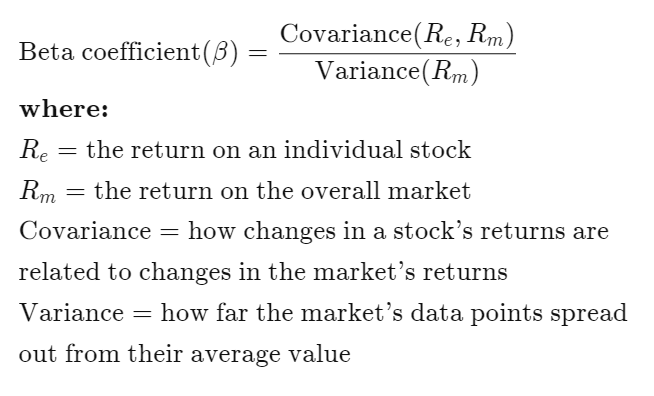

Source: https://www.investopedia.com/terms/b/beta.asp

$$
cov_{x,y} = \frac {\sum{(x_i - \bar{x})(y_i - \bar{y})}} {N-1}
$$
where $\bar{x}$ is the mean of x and $\bar{y}$ is the mean of y. N is the number of data values.

Alternatively, using the Expectation notation:
$$
cov_{x,y} = E[(X-E[X])(Y-E[Y])]
$$

Since $E[X]$ and $E[Y]$ are constant: 
$$
cov_{x,y} = E[XY - XE[Y] - YE[X] + E[X]E[Y]]
$$
$$
cov_{x,y} = E[XY] - E[X]E[Y] - E[Y]E[X] + E[X]E[Y]
$$
$$
cov_{x,y} = E[XY] - E[X]E[Y]
$$

In [227]:
#Since we are performing a trading strategy on NXE, we shall use URA as our benchmark
ticker = 'URA'
benchmark_data = yf.download(ticker, start='2019-01-01', end='2025-01-01', auto_adjust=True)
benchmark_data.index = pd.to_datetime(benchmark_data.index)
benchmark_data = benchmark_data.iloc[49:, 0] #Same starting point as SMA50
benchmark_data.name = 'Close'
benchmark_data = benchmark_data.to_frame()
benchmark_data.head(5)

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2019-03-14,10.314423
2019-03-15,10.446976
2019-03-18,10.438692
2019-03-19,10.471831
2019-03-20,10.529824


In [228]:
#V[Y] and E[Y]
benchmark_data['log_price'] = np.log(benchmark_data['Close'])
benchmark_data['log_return'] = benchmark_data['log_price'].pct_change()
benchmark_var = benchmark_data['log_return'].var()
benchmark_mean = benchmark_data['log_return'].mean()
print(f"Benchmark Mean: {benchmark_mean}, Benchmark Variance: {benchmark_var}")

#V[X] and E[X]
sma_20.df['log_price'] = np.log(sma_20.df['price'])
sma_20.df['log_return'] = sma_20.df['log_price'].pct_change()
sma_20_var = sma_20.df['log_return'].var()
sma_20_mean = sma_20.df['log_return'].mean()
print(f"SMA20 Mean: {sma_20_mean}, SMA20 Variance: {sma_20_var}")

#E[XY]
log_returns = np.mean(sma_20.df['log_return']*benchmark_data['log_return'])

#Covariance
sma_20_cov = log_returns - sma_20_mean*benchmark_mean
print(f'SMA20 Covariance: {sma_20_cov}')

#Covariance using NumPy
r1 = sma_20.df['log_return'].values[1:]
r2 = benchmark_data['log_return'].values[1:]
r_arr = np.vstack([r1, r2])
cov_matrix = np.cov(r_arr, rowvar=True)

#Notice the small differences in calculation, both are fine.
print(f"\nSMA20 Variance: {cov_matrix[0,0]}, Benchmark Variance: {cov_matrix[1,1]}")
print(f'SMA20 Covariance: {cov_matrix[0,1]}')

Benchmark Mean: 0.00027254944082951885, Benchmark Variance: 7.543402556127395e-05
SMA20 Mean: 0.0035678318206273994, SMA20 Variance: 0.08865610731833005
SMA20 Covariance: 9.578803730202926e-05

SMA20 Variance: 0.08865610731833008, Benchmark Variance: 7.543402556127393e-05
SMA20 Covariance: 9.585369051471055e-05


In [229]:
#Beta Calculation
beta = sma_20_cov/benchmark_var
print(f"Beta (Manual): {beta}")

def get_covariance(r1:np.array, r2:np.array) -> float:
    """
    Calculate the covariance between the return of Asset 1 and Asset 2.
    
    args:
        r1: Log Return of Asset 1, excluding the NaN values.
        r2: Log Return of Asset 2, excluding the NaN values.
        
    return:
        Covariance between the return of Asset 1 and Asset 2.
    """
    r_arr = np.vstack([r1,r2])
    cov_matrix = np.cov(r_arr, rowvar=True)
    return cov_matrix[0,1]

def get_beta(cov:float, benchmark_variance:float) -> float:
    return cov/benchmark_variance

sma_20_cov = get_covariance(r1, r2)
beta = get_beta(sma_20_cov, benchmark_var)
print(f"Beta (NumPy): {beta}")

Beta (Manual): 1.2698253419370022
Beta (NumPy): 1.270695681444841


### Treynor Ratio
Treynor Ratio is known as the rewards-to-volatility ratio. 

It measures how much excess return was generated for each unit of risk taken by the strategy. The higher the ratio, the better the risk-adjusted return.

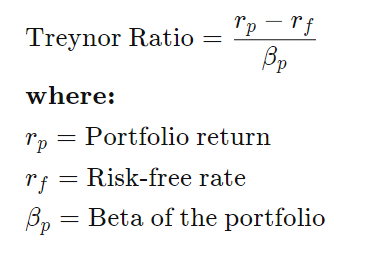

Source: https://www.investopedia.com/terms/t/treynorratio.asp

In [230]:
def treynor_ratio(portfolio_return:float, beta:float, risk_free:float=0) -> float:
    """
    Calculate the Treynor Ratio.
    
    args:
        portfolio_return: Average log return of the portfolio.
        beta: Beta of the portfolio.
        risk_free: Typically, the 3-month T-Bill Rate divided by 365. If strategy is intrday, put 0.
    
    return:
        Treynor Ratio for the portfolio.
    """
    return (portfolio_return-risk_free)/beta

print(treynor_ratio(sma_20_mean, beta, 0.042/365))

0.002717222839343217


In [231]:
for ln_return, sma_map in zip(ln_returns, sma_dicts):
    for t in timeframes:
        cov = get_covariance(ln_return, r2)
        exp_return, vol = expected_return_volatility(ln_return, t=t)
        beta = get_beta(cov, benchmark_var)
        metric = treynor_ratio(exp_return, beta, 0.042/365) #Daily returns: Daily risk-free rate
        key = f'Treynor ({t}-days)' if t != 0 else f'Treynor (Lifetime)'
        value = round(metric, 4)
        sma_map[key] = value
        print(f'{key}: {value}')
    print('')

Treynor (Lifetime): -0.0843
Treynor (30-days): -0.0512
Treynor (90-days): -0.0726
Treynor (180-days): -0.1046
Treynor (360-days): -0.0919

Treynor (Lifetime): -0.1192
Treynor (30-days): -0.0684
Treynor (90-days): -0.0729
Treynor (180-days): -0.1223
Treynor (360-days): -0.1177



### Information Ratio
Information ratio is similar to the Sharpe Ratio, but we replace the risk-free rate by a benchmark. The higher the ratio, the better the risk-adjusted return.
$$
\text{Information Ratio} = \frac {E[R_p - R_b]} {\sigma_{p-b}}
$$
where $R_p$ is the portfolio/strategy return for the period, $R_b$ is the benchmark return for the period,

and $\sigma_{p-b}$ is the standard deviation of difference between the portfolio return and the benchmark retrun, or called the tracking error.

In [232]:
tracking_error_return = r1 - r2
tracking_error = np.std(tracking_error_return)

def information_ratio(portfolio_return:float, benchmark_return:float, tracking_error:float) -> float:
    """
    Calculates the information ratio.
    
    args:
        portfolio_return: Average log return of the portfolio.
        benchmark_return: Average log return of the benchmark.
        tracking_error: The standard deviation of the difference between the log return of the portfolio and the benchmark.
    
    return:
        Information ratio for the portfolio
    """
    return (portfolio_return-benchmark_return)/tracking_error

print(information_ratio(sma_20_mean, benchmark_mean,tracking_error))

0.011078273084084933


In [233]:
for ln_return, sma_map in zip(ln_returns, sma_dicts):
    for t in timeframes:
        tracking_error = np.std(ln_return - r2)
        exp_return, vol = expected_return_volatility(ln_return, t=t)
        metric = information_ratio(exp_return, benchmark_mean, tracking_error)
        key = f'Information Ratio ({t}-days)' if t != 0 else f'Information Ratio (Lifetime)'
        value = round(metric, 4)
        sma_map[key] = value
        print(f'{key}: {value}')
    print('')

Information Ratio (Lifetime): -0.0453
Information Ratio (30-days): -0.0347
Information Ratio (90-days): -0.0416
Information Ratio (180-days): -0.0518
Information Ratio (360-days): -0.0477

Information Ratio (Lifetime): -0.0396
Information Ratio (30-days): -0.0305
Information Ratio (90-days): -0.0313
Information Ratio (180-days): -0.0402
Information Ratio (360-days): -0.0394



## Emotional Measures

No matter how profitable a strategy is, if an investor experiences long streaks of losses, he/she will withdraw the investment.

Hence, a strategy needs to win on the emotional side as well. This can be evaluated by loss streaks, maximum drawdown and etc.

### Drawdown and Maximum Drawdown
Drawdown (D) is the decline from a historical peak in cumulative wealth.
$$
\text{D(T)} = \max{(0, \frac {P(T) - P(t)} {P(T)})}  \qquad \text{where} \ t \in{[0, T]}
$$
where $P(T)$ is the recent peak price, and $P(t)$ is the price at the current time step.
<br><br>
Meanwhile, Maximum Drawdown (MDD) is the biggest drawdown in a given timeframe.
$$
\text{MDD(T)} = \min{D(\tau)}  \qquad \text{where} \ \tau \in{[0, T]}
$$
where $D(\tau)$ is the collection of drawdowns from time 0 to T.

In [234]:
def get_drawdown(price_series:pd.Series, t:int=0) -> list[float]:
    """
    Calculates the drawdowns from the peak in a given time period.
    
    args:
        price_series: A panda series of price values.
        t: If 0, calculate for the lifetime. Else, it will calculate for past t-days.
    
    return:
        drawdown: a list of all the drawdowns with a rolling peak. 
    """
    if t != 0:
        t = len(price_series) - t
        
    peak = price_series.iloc[t]
    drawdown = []
    for equity in price_series[t:].values:
        peak = max(peak, equity)
        d = max(0,((peak-equity)/peak))
        drawdown.append(d)
    return drawdown

drawdowns = get_drawdown(sma_20.df['equity'])
mdd = max(drawdowns)
sma_20_metrics['MDD (Lifetime)'] = mdd
print(f'Max Drawdown: {mdd:.2%}')

sma_20.df['drawdown_lifetime'] = drawdowns
sma_20.df.tail(10)

Max Drawdown: 16.25%


,price,equity,profit,win,SMA20_Cross,log_price,log_return,drawdown_lifetime
Date,,,,,,,,
2024-12-17,7.27,8383.080042,NaN,0.0,0,1.983756,-0.007513,0.161692
2024-12-18,6.98,8385.980042,NaN,0.0,0,1.943049,-0.020520,0.161402
2024-12-19,6.98,8385.980042,NaN,0.0,0,1.943049,0.000000,0.161402
2024-12-20,6.96,8386.180041,NaN,0.0,0,1.940179,-0.001477,0.161382
2024-12-23,7.00,8385.780042,NaN,0.0,0,1.945910,0.002954,0.161422
2024-12-24,6.91,8386.680043,NaN,0.0,0,1.932970,-0.006650,0.161332
2024-12-26,6.86,8387.180040,NaN,0.0,0,1.925707,-0.003757,0.161282
2024-12-27,6.83,8387.480042,NaN,0.0,0,1.921325,-0.002276,0.161252
2024-12-30,6.68,8388.980043,NaN,0.0,0,1.899118,-0.011558,0.161102


In [235]:
drawdowns = get_drawdown(sma_50.df['equity'])
mdd = max(drawdowns)
sma_50_metrics['MDD (Lifetime)'] = mdd
print(f'Max Drawdown: {mdd:.2%}')

sma_50.df['drawdown_lifetime'] = drawdowns
sma_50.df.tail(10)

Max Drawdown: 10.04%


,price,equity,profit,win,SMA50_Cross,drawdown_lifetime
Date,,,,,,
2024-12-17,7.27,9003.600001,NaN,0.0,0,0.09964
2024-12-18,6.98,9006.500000,NaN,0.0,0,0.09935
2024-12-19,6.98,9006.500000,NaN,0.0,0,0.09935
2024-12-20,6.96,9006.700000,NaN,0.0,0,0.09933
2024-12-23,7.00,9006.300000,NaN,0.0,0,0.09937
2024-12-24,6.91,9007.200002,NaN,0.0,0,0.09928
2024-12-26,6.86,9007.699999,NaN,0.0,0,0.09923
2024-12-27,6.83,9008.000001,NaN,0.0,0,0.09920
2024-12-30,6.68,9009.500002,NaN,0.0,0,0.09905


### Sterling Ratio
Sterling ratio evaluates the strategy’s performance relative to its downside risk, specifically focusing on the return achieved per unit of downside risk.

The higher the ratio, the better the risk-adjusted return.

$$
\text{Sterling Ratio} = \frac{E[R_p - R_f]}{E[\text{Annual MDD}]}
$$
where $R_p$ is the strategy return, $R_f$ is the risk-free return and $E[\text{Annual MDD}]$ is the three year average annual maximum drawdown.

In [236]:
def yearly_average_return(price_series:pd.Series) -> pd.Series:
    log_price = np.log(price_series.values)
    log_returns = log_price[1:] - log_price[:-1]
    log_series =  pd.Series(log_returns, index=price_series.index[1:])
    return log_series

def sterling_ratio(price_series:pd.Series, risk_free:float=0, t:int=3, recent_year:bool=False) -> float:
    """
    Calculate the Sterling Ratio.
    
    args:
        price_series: Index of datetime objects and prices as values.
        risk_free: Typically, the 3-month T-Bill Rate divided by 365. If strategy is intrday, put 0.
        t: Number of years to include in calculation of average annual maximum drawdown.
        recent_year: If True, will treat the current year as the latest year.
        
    return:
        Sterling Ratio: Return achieved per unit of downside risk.
    """
    log_series = yearly_average_return(price_series)
    portfolio_returns = log_series.groupby(log_series.index.year).aggregate('mean')
    annual_drawdowns = price_series.groupby(price_series.index.year).aggregate(get_drawdown).apply(lambda x: max(x))
    
    if recent_year:
        portfolio_return = np.mean(portfolio_returns.iloc[-t:].values)
        expected_mdd = np.mean(annual_drawdowns.iloc[-t:].values)
    else:
        portfolio_return = np.mean(portfolio_returns.iloc[-t:-1].values)
        expected_mdd = np.mean(annual_drawdowns.iloc[-t:-1].values) #Exclude recent year
        
    return (portfolio_return - risk_free)/expected_mdd

s_ratio = sterling_ratio(sma_20.df['equity'], 0.042) #Yearly return: Yearly risk-free rate
print(f'SMA20 Sterling Ratio: {s_ratio:.4f}')
sma_20_metrics['Sterling Ratio (3-Years)'] = s_ratio

s_ratio = sterling_ratio(sma_50.df['equity'], 0.042)
sma_50_metrics['Sterling Ratio (3-Years)'] = s_ratio
print(f'SMA50 Sterling Ratio: {s_ratio:.4f}')

SMA20 Sterling Ratio: -1.3008
SMA50 Sterling Ratio: -2.4519


### Lose Streak

In order to calculate lose streak, we will filter for positive and negative values.

Then, we will group the dataframe by streaks and get the length of each group, which will be the duration of that streak.

In [ ]:
def get_streaks(win_series:pd.Series) -> tuple[np.array, np.array]:
    """
    Get an array of win and lose streaks.
    
    args:
        win_series: A panda series where positive number indicates a win and negative number as a lost.
    
    return:
        A tuple of two arrays containing the durations of each new streak.
    """
    target_data = win_series.loc[(win_series>0) | (win_series<0)]
    target_data = np.sign(target_data.values)
    change_pts = np.insert((np.diff(target_data) != 0), 0, True) #Get change points and set first streak
    streak_ids = np.cumsum(change_pts) #Increase by 1 whenever a new streak begins
    streak_lengths = np.bincount(streak_ids)[1:] #Remove initial 0
    streak_type = target_data[np.where(change_pts)[0]] #Filter array to the indexes of the start of new streaks

    streaks = streak_lengths*streak_type
    win_streaks = streaks[streaks > 0].astype(int)
    lose_streaks = (streaks[streaks < 0]* -1).astype(int) #Reverse Sign
    return (win_streaks, lose_streaks)

sma_20_win_streak, sma_20_lose_streak = get_streaks(sma_20.df['win'])
print(f'Longest Win Streak {sma_20_win_streak.max()}')
print(f'Average Win Streak {sma_20_win_streak.mean()}')
print(f'\nLongest Lose Streak {sma_20_lose_streak.max()}')
print(f'Average Lose Streak {sma_20_lose_streak.mean():.2f}')

Longest Win Streak 1
Average Win Streak 1.0

Longest Lose Streak 33
Average Lose  Streak 9.39


In [390]:
sma_50_win_streak, sma_50_lose_streak = get_streaks(sma_50.df['win'])
print(f'Longest Win Streak {sma_50_win_streak.max()}')
print(f'Average Win Streak {sma_50_win_streak.mean():.2f}')
print(f'\nLongest Lose Streak {sma_50_lose_streak.max()}')
print(f'Average Lose Streak {sma_50_lose_streak.mean():.2f}')

Longest Win Streak 2
Average Win Streak 1.22

Longest Lose Streak 42
Average Lose Streak 12.22
